## **Loading Dataset**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
books = pd.read_csv('Books.csv')
ratings = pd.read_csv('Ratings.csv')
users = pd.read_csv('Users.csv')

In [3]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [5]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
print(books.shape)
print(users.shape)
print(ratings.shape)

(271360, 8)
(278858, 3)
(1149780, 3)


## **Data Preprocessing**

In [7]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [8]:
books.dropna(inplace=True)

In [9]:
users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [10]:
ratings.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [11]:
books.duplicated().sum()

0

In [12]:
users.duplicated().sum()

0

In [13]:
ratings.duplicated().sum()

0

## **Exploratory Data Analysis**

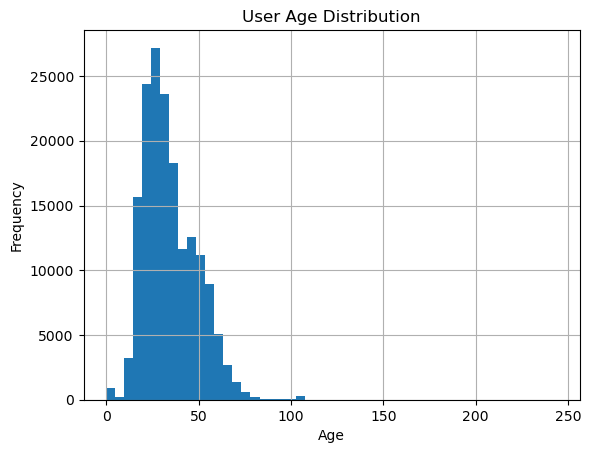

In [14]:
# Age distribution
users['Age'].describe()
users['Age'] = pd.to_numeric(users['Age'], errors='coerce')
users['Age'].hist(bins=50)
plt.title("User Age Distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

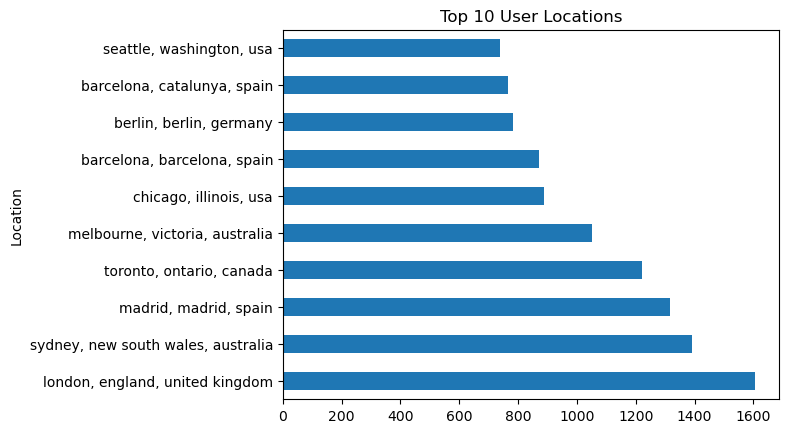

In [15]:
# Clean age
users = users[(users['Age'] >= 10) & (users['Age'] <= 90)]

# Top locations
users['Location'].value_counts()[:10].plot(kind='barh', title="Top 10 User Locations")
plt.show()

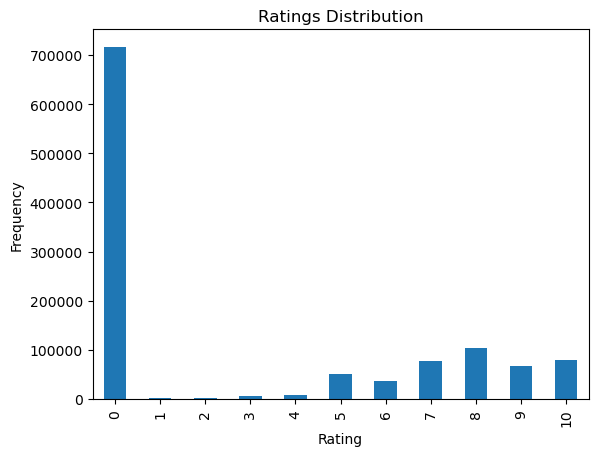

In [16]:
# Ratings distribution
ratings['Book-Rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

In [17]:
# Rating types
print("Implicit ratings (0):", ratings[ratings['Book-Rating'] == 0].shape[0])
print("Explicit ratings (1-10):", ratings[ratings['Book-Rating'] > 0].shape[0])

Implicit ratings (0): 716109
Explicit ratings (1-10): 433671


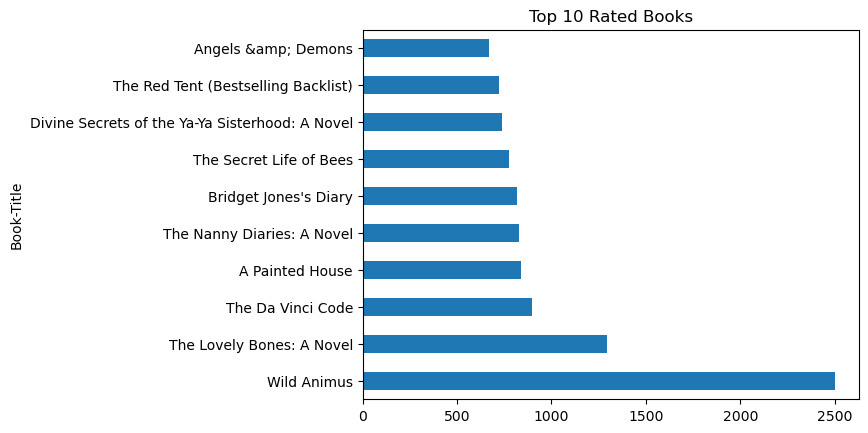

In [18]:
# Merge to check most rated books
combined = ratings.merge(books, on='ISBN')
top_books = combined['Book-Title'].value_counts()[:10]
top_books.plot(kind='barh', title="Top 10 Rated Books")
plt.show()

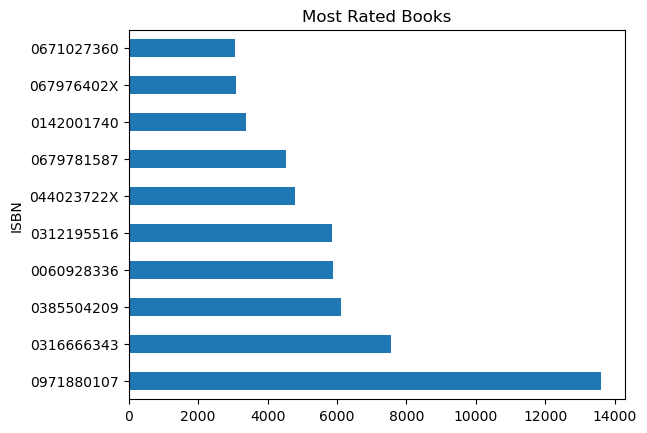

In [19]:
# Active users
user_ratings_count = ratings['User-ID'].value_counts()
user_ratings_count[:10].plot(kind='barh', title="Most Active Users")

# Books with most ratings
book_ratings_count = ratings['ISBN'].value_counts()
book_ratings_count[:10].plot(kind='barh', title="Most Rated Books")
plt.show()

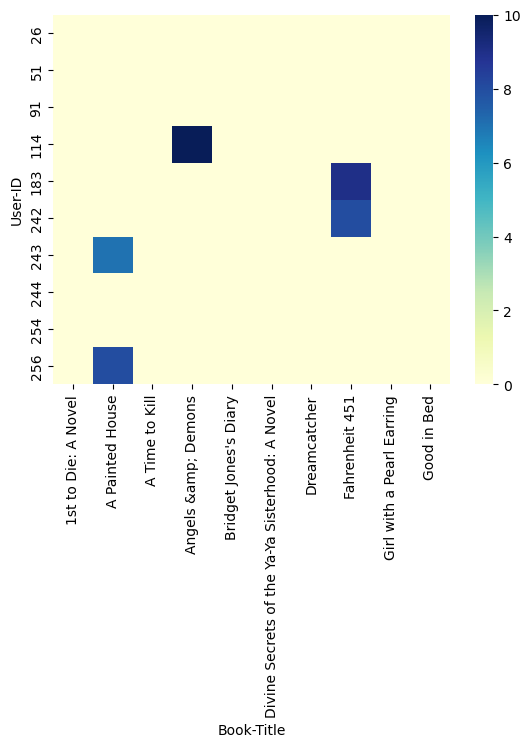

In [20]:
# Ratings pivot table (for collaborative filtering)
pivot_df = ratings[ratings['Book-Rating'] > 0].merge(books, on='ISBN')
top_books = pivot_df['Book-Title'].value_counts().head(50).index
pivot_df = pivot_df[pivot_df['Book-Title'].isin(top_books)]

pivot_table = pivot_df.pivot_table(index='User-ID', columns='Book-Title', values='Book-Rating')
sns.heatmap(pivot_table.fillna(0).iloc[:10,:10], cmap='YlGnBu')
plt.show()

In [21]:
book_stats = ratings[ratings['Book-Rating'] > 0].groupby('ISBN').agg({
    'Book-Rating': ['count', 'mean']
})
book_stats.columns = ['num_ratings', 'avg_rating']
book_stats = book_stats.sort_values('num_ratings', ascending=False)
print(book_stats.head(10))

            num_ratings  avg_rating
ISBN                               
0316666343          707    8.185290
0971880107          581    4.390706
0385504209          487    8.435318
0312195516          383    8.182768
0679781587          333    8.408408
0060928336          320    7.887500
059035342X          313    8.939297
0142001740          307    8.452769
0446672211          295    8.142373
044023722X          281    7.338078


## **Popularity Based Recommender System**

In [22]:
ratings_with_name = ratings.merge(books,on='ISBN')

In [23]:
ratings_with_name.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...


In [24]:
num_rating_df = ratings_with_name.groupby('Book-Title').count()['Book-Rating'].reset_index()
num_rating_df.rename(columns={'Book-Rating':'num_ratings'},inplace=True)
num_rating_df.head()

,Book-Title,num_ratings
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [25]:
avg_rating_df = ratings_with_name.groupby('Book-Title')['Book-Rating'].mean().reset_index()
avg_rating_df.rename(columns={'Book-Rating': 'avg_ratings'}, inplace=True)
avg_rating_df.head()

,Book-Title,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,2.25
1,Always Have Popsicles,0.00
2,Apple Magic (The Collector's series),0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",8.00
4,Beyond IBM: Leadership Marketing and Finance ...,0.00


In [26]:
popularity_df = num_rating_df.merge(avg_rating_df, on='Book-Title')
popularity_df.head()

,Book-Title,num_ratings,avg_ratings
0,A Light in the Storm: The Civil War Diary of ...,4,2.25
1,Always Have Popsicles,1,0.00
2,Apple Magic (The Collector's series),1,0.00
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,8.00
4,Beyond IBM: Leadership Marketing and Finance ...,1,0.00


In [27]:
popularity_df = popularity_df[popularity_df['num_ratings']>=250].sort_values('avg_ratings',ascending=False).head(50)

In [28]:
popularity_df = popularity_df.merge(books,on='Book-Title').drop_duplicates('Book-Title')[['Book-Title','Book-Author','Image-URL-M','num_ratings','avg_ratings']]

In [29]:
popularity_df

,Book-Title,Book-Author,Image-URL-M,num_ratings,avg_ratings
0,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,http://images.amazon.com/images/P/0439136350.0...,428,5.852804
3,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,http://images.amazon.com/images/P/0439139597.0...,387,5.824289
5,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,http://images.amazon.com/images/P/0590353403.0...,278,5.737410
9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,http://images.amazon.com/images/P/043935806X.0...,347,5.501441
13,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,http://images.amazon.com/images/P/0439064872.0...,556,5.183453
16,The Hobbit : The Enchanting Prelude to The Lor...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339681.0...,281,5.007117
17,The Fellowship of the Ring (The Lord of the Ri...,J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339703.0...,368,4.948370
26,Harry Potter and the Sorcerer's Stone (Harry P...,J. K. Rowling,http://images.amazon.com/images/P/059035342X.0...,575,4.895652
28,"The Two Towers (The Lord of the Rings, Part 2)",J.R.R. TOLKIEN,http://images.amazon.com/images/P/0345339711.0...,260,4.880769
39,To Kill a Mockingbird,Harper Lee,http://images.amazon.com/images/P/0446310786.0...,510,4.700000


## **Collaborative Filtering Recommender System**

In [30]:
x = ratings_with_name.groupby('User-ID').count()['Book-Rating'] > 200
users_with_high_rating_count = x[x].index
filtered_ratings = ratings_with_name[ratings_with_name['User-ID'].isin(users_with_high_rating_count)]

In [31]:
y = filtered_ratings.groupby('Book-Title').count()['Book-Rating'] >= 50
famous_books = y[y].index
final_ratings = ratings_with_name[ratings_with_name['Book-Title'].isin(famous_books)]

In [32]:
pt = final_ratings.pivot_table(index='Book-Title', columns='User-ID',values='Book-Rating')

In [33]:
pt.fillna(0,inplace=True)

In [34]:
pt.head()

User-ID,8,9,14,16,17,26,32,39,42,44,...,278813,278819,278824,278828,278832,278836,278843,278844,278846,278854
Book-Title,,,,,,,,,,,,,,,,,,,,,
1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Bend in the Road,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
from sklearn.metrics.pairwise import cosine_similarity

In [36]:
similarity_score = cosine_similarity(pt)

In [37]:
similarity_score.shape

(706, 706)

In [38]:
def recommend(book_name):
    # index fetch
    index = np.where(pt.index==book_name)[0][0]
    similar_items = sorted(list(enumerate(similarity_scores[index])),key=lambda x:x[1],reverse=True)[1:5]
    
    data = []
    for i in similar_items:
        item = []
        temp_df = books[books['Book-Title'] == pt.index[i[0]]]
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Title'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Book-Author'].values))
        item.extend(list(temp_df.drop_duplicates('Book-Title')['Image-URL-M'].values))
        
        data.append(item)
    
    return data

In [39]:
books.drop_duplicates('Book-Title')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271354,0449906736,Flashpoints: Promise and Peril in a New World,Robin Wright,1993,Ballantine Books,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...,http://images.amazon.com/images/P/0449906736.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [43]:
import pickle
pickle.dump(popularity_df,open('popularity.pkl','wb'))
pickle.dump(pt,open('pt.pkl','wb'))
pickle.dump(books,open('books.pkl','wb'))
pickle.dump(similarity_score,open('similarity_score.pkl','wb'))